In [1]:
!pip install mne
!pip install livelossplot
!pip install wget
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 109.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.3/296.3 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=d67d8d33eefec8d65ba0ba6b5b01b8cb8010923ac194659bebff5aaeadb31c2b
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 23.2 MB/s eta 0:00:00


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from models.model import EEGClassifier
from data_utils import Utils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
channels = [["FC1", "FC2"],
            ["FC3", "FC4"],
            ["FC5", "FC6"],
            ["C5", "C6"],
            ["C3", "C4"],
            ["C1", "C2"],
            ["CP1", "CP2"],
            ["CP3", "CP4"],
            ["CP5", "CP6"]]

In [5]:
exclude =  [38, 88, 89, 92, 100, 104]
subjects = [n for n in np.arange(1,110) if n not in exclude]
source_path = 'data/'
x, y = Utils.load(channels, subjects, base_path=source_path)

In [6]:
y_one_hot  = Utils.to_one_hot(y, by_sub=False)
reshaped_x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

In [7]:
x_train_raw, x_valid_test_raw, y_train_raw, y_valid_test_raw = train_test_split(reshaped_x,
                                                                            y_one_hot,
                                                                            stratify=y_one_hot,
                                                                            test_size=0.20,
                                                                            random_state=42)

In [8]:
x_train_scaled_raw = minmax_scale(x_train_raw, axis=1)
x_test_valid_scaled_raw = minmax_scale(x_valid_test_raw, axis=1)

x_valid_raw, x_test_raw, y_valid, y_test = train_test_split(x_test_valid_scaled_raw,
                                                    y_valid_test_raw,
                                                    stratify=y_valid_test_raw,
                                                    test_size=0.50,
                                                    random_state=42)

x_valid = x_valid_raw.reshape(x_valid_raw.shape[0], int(x_valid_raw.shape[1]/2),2).astype(np.float64)
x_test = x_test_raw.reshape(x_test_raw.shape[0], int(x_test_raw.shape[1]/2),2).astype(np.float64)

In [9]:
print('classes count')
print ('before oversampling = {}'.format(y_train_raw.sum(axis=0)))

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_train_smote_raw, y_train = sm.fit_resample(x_train_scaled_raw, y_train_raw)
print('classes count')
print ('before oversampling = {}'.format(y_train_raw.sum(axis=0)))
print ('after oversampling = {}'.format(y_train.sum(axis=0)))

x_train = x_train_smote_raw.reshape(x_train_smote_raw.shape[0], int(x_train_smote_raw.shape[1]/2), 2).astype(np.float64)


classes count
before oversampling = [66744. 16553. 16826. 16610. 16546.]
classes count
before oversampling = [66744. 16553. 16826. 16610. 16546.]
after oversampling = [66744 66744 66744 66744 66744]


In [10]:
learning_rate = 1e-4
checkpoint_path = 'model_checkpoints/'
if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)
loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = EEGClassifier()
modelPath = os.path.join(checkpoint_path, 'bestModel.h5')

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


In [11]:
checkpoint = ModelCheckpoint(
    modelPath,
    monitor='val_acc',
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=1 
)

earlystopping = EarlyStopping(
    monitor='val_acc', 
    min_delta=0.001, 
    patience=4, 
    restore_best_weights=True, 
    verbose=0, 
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
     factor=0.5, patience=4, 
     verbose=1, mode='auto', 
     min_lr=0.0000001
)
callbacksList = [checkpoint, earlystopping, reduce_lr, PlotLossesKeras()]

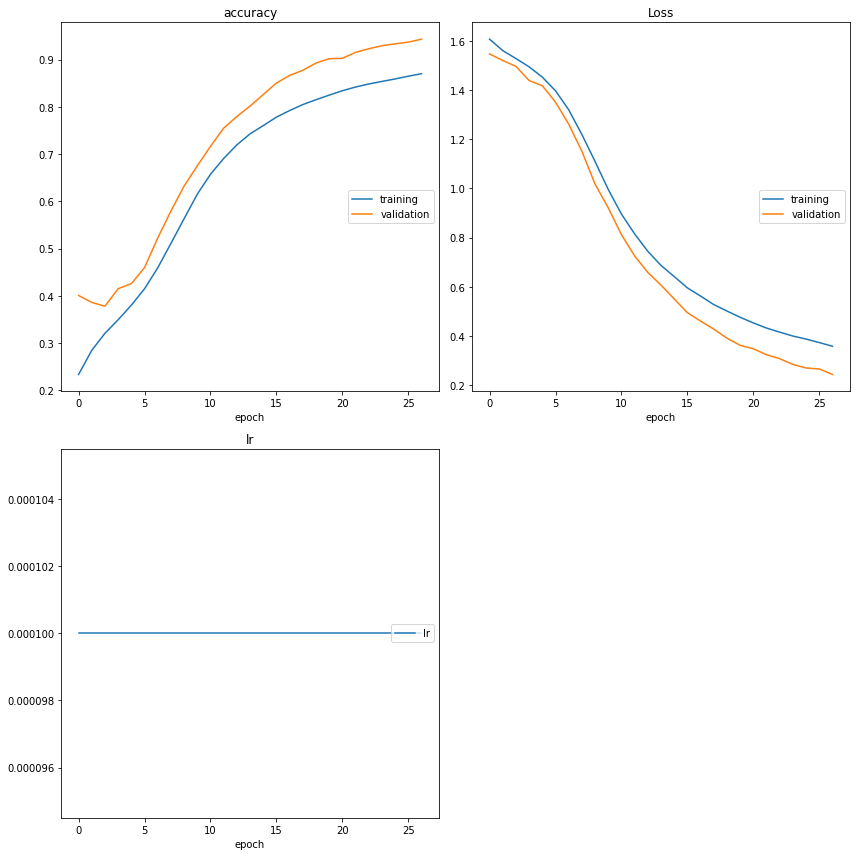

accuracy
	training         	 (min:    0.233, max:    0.870, cur:    0.870)
	validation       	 (min:    0.378, max:    0.943, cur:    0.943)
Loss
	training         	 (min:    0.358, max:    1.606, cur:    0.358)
	validation       	 (min:    0.244, max:    1.546, cur:    0.244)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
652/652 [==============================] - 18s 28ms/step - loss: 0.3584 - accuracy: 0.8703 - val_loss: 0.2440 - val_accuracy: 0.9435 - lr: 1.0000e-04
Epoch 28/100
585/652 [=========================>....] - ETA: 1s - loss: 0.3468 - accuracy: 0.8749

KeyboardInterrupt: 

In [12]:
import warnings 
warnings.filterwarnings('ignore')
import logging
tf.get_logger().setLevel(logging.ERROR)
hist = model.fit(x_train, y_train, epochs=100, batch_size=512,
                validation_data=(x_valid, y_valid), callbacks=callbacksList, verbose=1) 


In [22]:
model.weights

[<tf.Variable 'eeg_classifier/conv1d/kernel:0' shape=(20, 2, 32) dtype=float32, numpy=
 array([[[-0.03105841,  0.02133787,  0.09362642, ..., -0.04845575,
           0.02343942,  0.01163678],
         [-0.06685983, -0.01759335, -0.08735242, ...,  0.05176568,
           0.07451265, -0.03130338]],
 
        [[ 0.00296922,  0.01841027, -0.00372879, ...,  0.09167968,
           0.09789763, -0.04734095],
         [ 0.10070264, -0.06884103,  0.09115031, ..., -0.07207972,
          -0.01559599,  0.01815959]],
 
        [[ 0.09469974,  0.06484924,  0.06668682, ..., -0.00242376,
           0.03124655, -0.00344778],
         [-0.04560961, -0.1014864 , -0.0587475 , ...,  0.06947574,
          -0.01428343,  0.00035909]],
 
        ...,
 
        [[-0.00398382, -0.029262  ,  0.01960748, ..., -0.03326162,
           0.03268471, -0.10928274],
         [ 0.0130912 , -0.012501  ,  0.02309103, ...,  0.04876432,
          -0.03939115, -0.02447149]],
 
        [[-0.03782549, -0.03699069,  0.07709341, ..., 

In [39]:
np.random.rand(1, 640, 2).shape

(1, 640, 2)

In [40]:
model1 = EEGClassifier()
model1.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model1(np.random.rand(1, 640, 2))
model1.load_weights('experiments/'+save_path)

In [14]:
save_path = os.path.join(checkpoint_path, 'bestModel_v2.h5')

model.save_weights(save_path)


In [36]:
x_test.shape

(16660, 640, 2)

In [34]:

testLoss, testAcc = model1.evaluate(x_test, y_test)
print('\nAccuracy:', testAcc)
print('\nLoss: ', testLoss)

from sklearn.metrics import classification_report, confusion_matrix
yPred = model1.predict(x_test)

yTestClass = np.argmax(y_test, axis=1)
yPredClass = np.argmax(yPred,axis=1)

print('\n Classification report \n\n',
  classification_report(
      yTestClass,
      yPredClass,
       target_names=["B", "R", "RL", "L", "F"]
      )
  )

print('\n Confusion matrix \n\n',
  confusion_matrix(
      yTestClass,
      yPredClass,
      )
  )


521/521 [==============================] - 1s 2ms/step - loss: 0.2365 - accuracy: 0.9463

Accuracy: 0.9463385343551636

Loss:  0.2364695519208908
521/521 [==============================] - 1s 1ms/step

 Classification report 

               precision    recall  f1-score   support

           B       0.97      0.94      0.95      8343
           R       0.93      0.96      0.95      2069
          RL       0.92      0.96      0.94      2103
           L       0.93      0.96      0.94      2077
           F       0.92      0.95      0.93      2068

    accuracy                           0.95     16660
   macro avg       0.94      0.95      0.94     16660
weighted avg       0.95      0.95      0.95     16660


 Confusion matrix 

 [[7823  118  139  126  137]
 [  55 1984   15    6    9]
 [  71    6 2014    6    6]
 [  67    6    5 1984   15]
 [  79   12   14    2 1961]]


In [16]:

testLoss, testAcc = model.evaluate(x_test, y_test)
print('\nAccuracy:', testAcc)
print('\nLoss: ', testLoss)

from sklearn.metrics import classification_report, confusion_matrix
yPred = model.predict(x_test)

yTestClass = np.argmax(y_test, axis=1)
yPredClass = np.argmax(yPred,axis=1)

print('\n Classification report \n\n',
  classification_report(
      yTestClass,
      yPredClass,
       target_names=["B", "R", "RL", "L", "F"]
      )
  )

print('\n Confusion matrix \n\n',
  confusion_matrix(
      yTestClass,
      yPredClass,
      )
  )


521/521 [==============================] - 1s 2ms/step - loss: 0.2365 - accuracy: 0.9463

Accuracy: 0.9463385343551636

Loss:  0.2364695519208908
521/521 [==============================] - 1s 1ms/step

 Classification report 

               precision    recall  f1-score   support

           B       0.97      0.94      0.95      8343
           R       0.93      0.96      0.95      2069
          RL       0.92      0.96      0.94      2103
           L       0.93      0.96      0.94      2077
           F       0.92      0.95      0.93      2068

    accuracy                           0.95     16660
   macro avg       0.94      0.95      0.94     16660
weighted avg       0.95      0.95      0.95     16660


 Confusion matrix 

 [[7823  118  139  126  137]
 [  55 1984   15    6    9]
 [  71    6 2014    6    6]
 [  67    6    5 1984   15]
 [  79   12   14    2 1961]]
